# Instrucciones.

Debería poder realizar todo el laboratorio en 3 horas.

**Recomendamos fuertemente** que siga trabajando en el laboratorio durante las horas asignadas, pues así puede consultar en vivo dudas que tenga sobre las partes finales del mismo. 

...
...


# A. Datos grupo

Escriba en esta celda el nombre de cada integrante de su grupo.

- Integrante 1: XXX

- Integrante 2: YYY

 # B. Preparación.

### B1. Paquetes y Ambiente 

Usaremos los paquetes `JuMP, Gurobi, Plots, CSV, DataFrames`
   Asegúrese de tener la última versión de `JuMP` corriendo (0.21.2 en mayo 2020)
   Si le falta algún paquete instálelo (`using Pkg`; `Pkg.add("nombre_paquete")`) o actualícelo (`Pkg.update("nombre_paquete")`)
 
Al igual que en el laboratorio anterior, cree una constante `GUROBI_ENV` que guarde el ambiente gurobi que usaremos
(de modo de evitar múltiples instancias). 
 

In [1]:
using JuMP, Gurobi, Plots, CSV, DataFrames
const GUROBI_ENV = Gurobi.Env()

Academic license - for non-commercial use only


Gurobi.Env(Ptr{Nothing} @0x00000000051a1b20)

## B2. Rectángulos en el plano: definiciones y funciones auxiliares

Hoy trabajaremos con problemas relacionados con rectángulos en el plano.
   
Para $(a,b,c,d)\in \mathbb{Z}$, denotamos por $\text{rect}(a, b, c, d)=[a, c] \times [b, d] \subseteq \mathbb{Z}^2$  al rectángulo cerrado con lados alineados con los ejes, de esquina inferior izquierda $(a, b)$ y esquina superior derecha $(c, d)$. 
  
Describiremos familias de $n$ rectángulos como matrices $R\in \mathbb{Z}^{n\times 4}$ cuya $i$-ésima fila es $[a_i, b_i, c_i, d_i]$. El $i$-ésimo rectángulo de la familia es $\text{rect}(a_i,b_i,c_i,d_i)$
 
Revisar si dos rectángulos se intersectan es simple:
$$\text{rect}(a,b,c,d) \cap \text{rect}(a',b',c',d')\neq \emptyset \iff (\max(a,a')\leq \min(c,c')) \wedge (\max(b,b')\leq \min(c,c')$$  
 
Decimos que un conjunto $R$ de rectángulos es **independiente** si son disjuntos de a pares. 

Llamamos **área discreta** de un rectángulo $r$ al número de puntos enteros que este rectángulo contiene.

A continuación incluimos 4 funciones auxiliares para usar en este laboratoio

1. ``LeeArchivo(archivocsv)``
   Lee un archivo de nombre "archivocsv" que contiene una familia de rectángulo, devolviéndolo en formato matriz.
   
2. ``Intersecta(rect1,rect2)`` 
   Determina rápidamente si dos rectángulos se intersectan (devuelve true/false)
    
3. ``AreaDiscreta(rect)``
   Determina el área discreta del rectángulo
   
4. ``Dibuja(R)``
   Dibujar familias de rectángulos en el plano (les aumenta el grosor para permitir rectangulos de ancho o alto 0)
  

In [2]:
function LeeArchivo(archivocsv)
    return Matrix(CSV.read(archivocsv,  header=0))
end

function Intersecta(rect1,rect2)
    return (max(rect1[1],rect2[1])<=min(rect1[3],rect2[3])) & (max(rect1[2],rect2[2])<=min(rect1[4],rect2[4]))
end

function AreaDiscreta(rect)
    return (rect[3]-rect[1]+1)*(rect[4]-rect[2]+1)
end

function Dibuja(R)
    N=maximum(R)
    plot()
    for i in 1:size(R,1)
       plot!(
            Shape([R[i,1]-0.1, R[i,3]+0.1, R[i,3]+0.1, R[i,1]-0.1], [R[i,2]-0.1, R[i,2]-0.1, R[i,4]+0.1, R[i,4]+0.1]),
            xlims=(0.85,N+0.15),
            ylims=(0.85,N+0.15),
            opacity=.5, legend=false, aspect_ratio=1)
    end
    display(plot!())
end

Dibuja (generic function with 1 method)

Como ejemplo, las siguientes lineas crean una matriz F de rectángulos a partir del archivo "rectangulos00.csv" y luego la dibujan

In [3]:
F=LeeArchivo("rectangulos00.csv")

6×4 Array{Int64,2}:
 1  3  3  4
 2  3  4  5
 1  1  2  2
 5  3  5  4
 4  4  4  5
 2  2  4  2

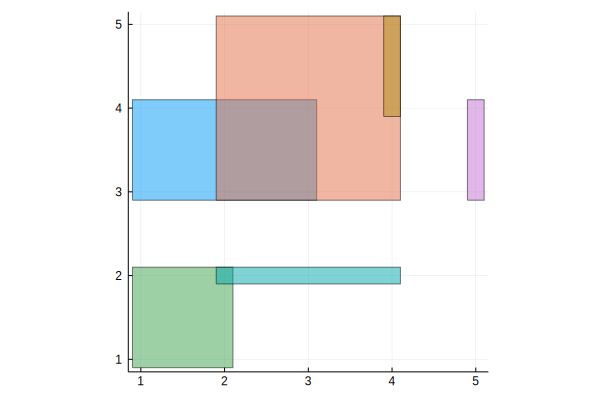

In [4]:
Dibuja(F)

Por ejemplo, en el caso de la familia $F$ anterior, podemos calcular las áreas discretas de los 6 rectángulos como sigue:

In [5]:
for i in 1:size(F,1)
    println("Rectangulo ", i, " cubre ", AreaDiscreta(F[i,:]), " puntos enteros")
end

Rectangulo 1 cubre 6 puntos enteros
Rectangulo 2 cubre 9 puntos enteros
Rectangulo 3 cubre 4 puntos enteros
Rectangulo 4 cubre 2 puntos enteros
Rectangulo 5 cubre 2 puntos enteros
Rectangulo 6 cubre 3 puntos enteros


Y podemos calcular la intersección par a par de los rectángulos de $F$ como sigue

In [6]:
[Intersecta(F[i,:], F[j,:]) for i=1:size(F,1), j=1:size(F,1)]

6×6 Array{Bool,2}:
 1  1  0  0  0  0
 1  1  0  0  1  0
 0  0  1  0  0  1
 0  0  0  1  0  0
 0  1  0  0  1  0
 0  0  1  0  0  1

Notamos que los rectangulos 1, 3, 4 y 5 forman un conjunto independiente. Podemos dibujar ese subconjunto escribiendo:

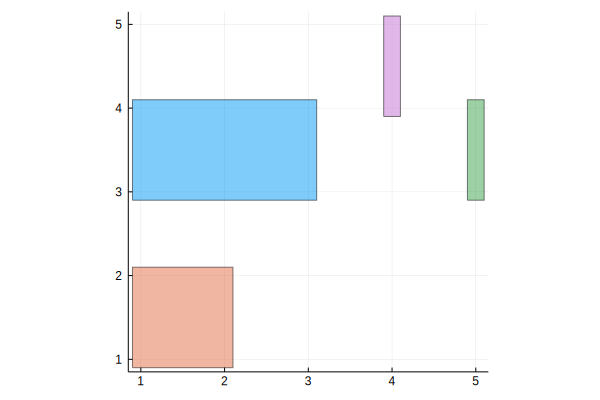

In [7]:
Dibuja(F[[1, 3, 4, 5],:])

# C. Conjunto Independiente máximo de rectángulos (Modelo)

 El problema del **conjunto independiente máximo de rectángulos (MISR)** se define como sigue:
   
  **Entrada:**
  
  Una familia $R$ de $n$ rectángulos codificada como una matriz (del mismo nombre) $R\in \mathbb{Z}^{n\times 4}$ cuya $i$-ésima fila es $[a_i, b_i, c_i, d_i]$. 
  El $i$-ésimo rectángulo de la familia es $r_i=\text{rect}(a_i,b_i,c_i,d_i)$
  
  **Salida:**
  
  Un conjunto $X\subseteq R$ de rectángulos independientes de cardinal máximo.
  
  
  
  La formulación natural del problema como PLE es la siguiente (aquí $n$ es el número de rectángulos).
  
  $$(PE1)\quad \begin{align*}
  \max &\sum_{i=1} x_i\\
  x_i +x_j &\leq 1, \quad \forall 1\leq i<j\leq n: r_i\cap r_j \neq \emptyset\\
  x_i &\in \{0,1\}, \quad \forall i\in [n]
  \end{align*}
  $$
  
  también usaremos la siguiente relajación (PL1)
  $$(PL1)\quad \begin{align*}
  \max &\sum_{i=1} x_i\\
  x_i +x_j &\leq 1, \quad \forall 1\leq i<j\leq n: r_i\cap r_j \neq \emptyset\\
  0\leq x_i &\leq 1, \quad \forall i\in [n]
  \end{align*}
  $$
  
  
  

**IMPORTANTE:** 

En este laboratorio trabajaremos en resolver (PE1) para pequeñas instancias. Esta vez interactuaremos con el solver de distintas maneras: asignando prioridades, o cambiando características. ``JuMP`` no permite trabajar directamente con todas las funcionalidades de Gurobi, y es necesario usar paquetes de más bajo nivel como ``MathOptInterface`` (abreviado ``MOI``)

Para hacer todo más simple, usaremos la siguiente función que recibe un modelo y una matriz de dos columnas donde cada fila es de la forma ``["opcion", valor-opcion]`` que queramos pasarle a Gurobi. La lista de parámetros que Gurobi acepta está en  https://www.gurobi.com/documentation/9.0/refman/parameters.html

Por ejemplo, si m contiene un modelo y deseamos fijar el parámetro "TimeLimit" del solver a 30 segundos, y el parámetro "Presolve" a 0 podemos escribir
``Modifica(m, ["TimeLimit" 30; "Presolve" 0])``


In [47]:
function Modifica(mimodelo, X)
    k=size(X,1)
    for j in 1:k
        MOI.set(mimodelo, MOI.RawParameter(X[j,1]), X[j,2])
        #println("",X[j,1],"=>",X[j,2])
    end
end

Modifica (generic function with 1 method)

## Ejercicio 1:

*  Los archivos "rectangulosxx.csv" donde xx está en el conjunto {01, 02, ..., 20} contienen familias de rectángulos de prueba.

Este ejercicio tiene 3 partes 

a) Escribir una función ModeloMISR que cree el modelo PE1 (o PL1) a partir de un archivo y que fije opciones estándar a fijar luego.

b) Escribir una función ResolverMISR(modeloR) que optimice el modelo ``modeloR`` y, en caso de encontrar óptimo, dibuje la salida
   
c) Ejecutar la función ResolverMISR en tres instancias de prueba.


### 1.a)

Escriba una función ModeloMISR que siga la siguiente sintaxis de entrada y salida:

```julia
function ModeloMISR(familia, integral=1)
return modeloR
```
donde la salida es

* `modeloR` es un objeto de tipo Model (creado por JuMP) basado en la formulación (PE).

y la entrada es

* `familia`:  Matriz que tiene los rectángulos de la familia

El parámetro "integral" puede ser 0 o 1 y es opcional. Si es 1 debe crear el modelo (PE), si es 0 debe crear el modelo (PL)


Su función debe fijar los siguientes parámetros en el modelo 

 "OutputFlag" 1  <- activa la salida del solver
 
 "TimeLimit" 30  <- limite de tiempo
 
 "Presolver" 0   <- desactiva el presolver
 
 "Threads" 1     <- desactiva el paralelismo (1 solo thread se permite)
 
 "Cuts" 0        <- desactiva la generación de cortes.
   
"Heuristics" 0 <- desactiva las heurísticas

In [48]:
function ModeloMISR(familia, integral=1)
    # Paso 1, crear modelo. Aqui se usa el parámetro cotatiempo
    modeloR = Model(optimizer_with_attributes(
                () -> Gurobi.Optimizer(GUROBI_ENV)))
    
    # Paso 2 cree las variables, objetivo, y restricciones  del modelo
    # rectangulos
    n = size(familia, 1)   
        
    # sugerencia: use if-else para determinar si cada x es Binaria, o si 0<=x<=1
    if integral==1
        @variable(modeloR, x[1:n], Bin)
    else
        @variable(modeloR, 0<=x[1:n]<=1)
    end
                    
    @objective(modeloR, Max, sum(x))                
    
    #sugerencia use restricciones sin nombre
    for i=1:n, j=1:n;
        if i<j && Intersecta(familia[i,:], familia[j,:])
             @constraint(modeloR, x[i]+x[j]<=1)
        end
    end
    
    # Paso 4, active los 5 parámetros solicitados 
    Modifica(modeloR, ["OutputFlag" 0; "TimeLimit" 30; "Presolve" 0; "Threads" 1; "Cuts" 0; "Heuristics" 0])                 
        
    return modeloR
end

ModeloMISR (generic function with 2 methods)

1.b) 
Escriba una función ResolverMISR que siga la siguiente sintaxis de entrada y salida:

```julia
function ResolverMISR(modeloR)
    # si no alcanza a terminar (por limite de tiempo)
    # debe arrojar un @error("Limite de tiempo alcanzado")
    #
    # antes de retornar, debe dibujar el conjunto S
    return valor_objetivo, S
```

Aquí `valor_objetivo` es el valor objetivo del problema, y `S` es la submatriz de R con los rectángulos ** en el soporte de la solución ** es decir, los rectángulos $r$ con $x_r>=eps$ para una tolerancia $eps=0.001$.

Para escribir la función puede usar la siguiente plantilla.

In [49]:
function ResolverMISR(familia,  integral=1)
    # cree modelo
    modeloR = ModeloMISR(familia, integral)
    
    # optimizar, extraer objetivos y valores
    optimize!(modeloR)
    if termination_status(modeloR) == MOI.TIME_LIMIT
        @error("Límite de tiempo alcanzado")
    end
    
    valor_objetivo = objective_value(modeloR)
    eps = 0.001
    S = findall(x->x>=eps, value.(modeloR[:x]))  #matriz asociada a los coeficientes de x con valor >=eps
    
    # dibujar S
    Dibuja(familia[S,:])
    # entregar
    return valor_objetivo, S
    
end

ResolverMISR (generic function with 2 methods)

### 1.c) 
Ejecute la función ResolverMISR en las instancia de pruebas "rectangulosxx.csv" con xx=01, 02, 03.
Haga esto para cada una dos veces, de manera integral y fraccional.
Verifique si hay alguna instancia en la que la solución integral y la solución fraccional son idénticas.
(¿Por qué cree que esto ocurre? Hint: Visualice las instancias)

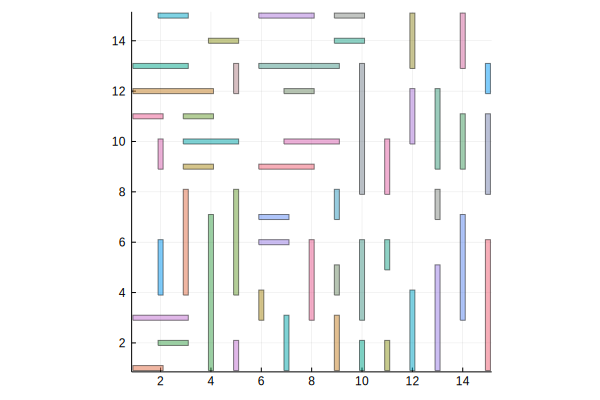

(51.0, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  66, 67, 69, 70, 71, 72, 73, 74, 75, 90])

In [50]:
valor_objetivo, S = ResolverMISR(LeeArchivo("rectangulos01.csv"),0)

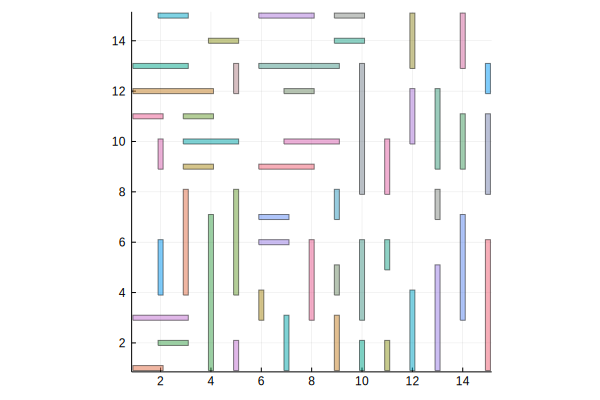

OutputFlag=>0
TimeLimit=>30
Presolve=>0
Threads=>1
Cuts=>0
Heuristics=>0


(51.0, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  66, 67, 69, 70, 71, 72, 73, 74, 75, 90])

In [12]:
valor_objetivo, S = ResolverMISR(LeeArchivo("rectangulos01.csv"),1)

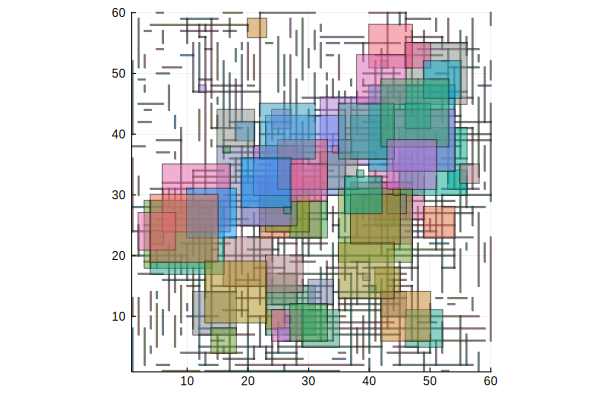

(298.5, [1, 2, 3, 4, 5, 6, 7, 8, 9, 11  …  568, 569, 570, 571, 572, 573, 574, 575, 577, 579])

In [51]:
valor_objetivo, S = ResolverMISR(LeeArchivo("rectangulos02.csv"),0)

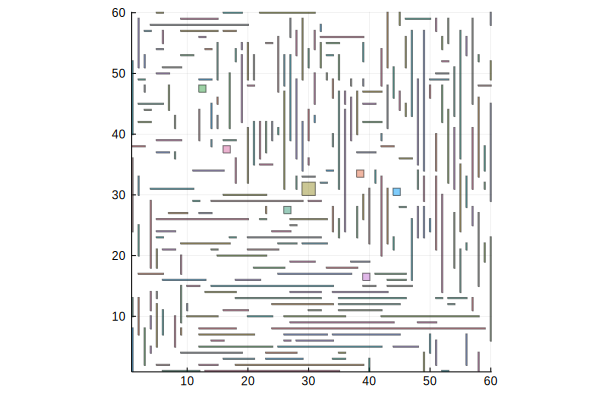

OutputFlag=>0
TimeLimit=>30
Presolve=>0
Threads=>1
Cuts=>0
Heuristics=>0


(274.0, [1, 2, 3, 4, 5, 6, 8, 9, 40, 49  …  469, 470, 472, 496, 529, 535, 546, 559, 561, 568])

In [14]:
valor_objetivo, S = ResolverMISR(LeeArchivo("rectangulos02.csv"),1)

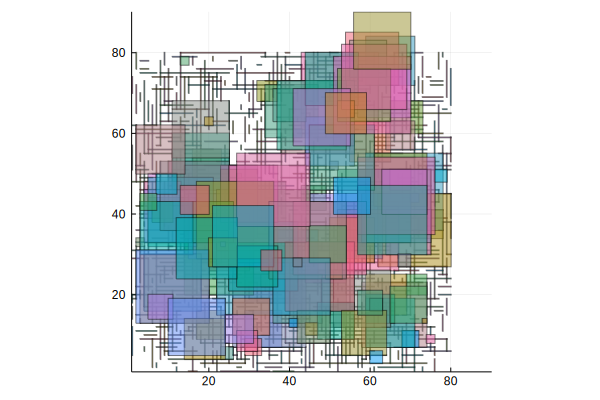

(486.0, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  951, 952, 953, 954, 955, 956, 957, 958, 959, 960])

In [52]:
valor_objetivo, S = ResolverMISR(LeeArchivo("rectangulos03.csv"),0)

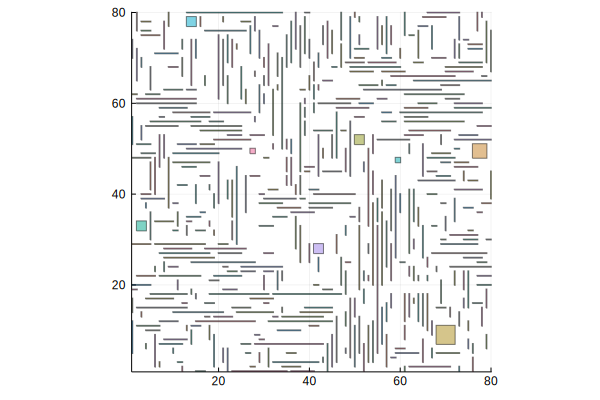

(462.0, [1, 3, 4, 6, 7, 10, 12, 13, 14, 18  …  795, 800, 811, 826, 846, 861, 868, 875, 906, 942])

In [53]:
valor_objetivo, S = ResolverMISR(LeeArchivo("rectangulos03.csv"),1)

En la instancia **rectangulos01.csv** la solución LP es integral, esto sugiere que la matriz de incidencia $A$ es total unimodular, una forma sencilla de probar esto es ver si el grafo es bipartito, en efecto, al graficar los parámetros se observa que los rectangulos verticales solo se intersectan con los rectangulos horizontales y viceversa, por lo que a un lado del grafo podríamos colocar los rectangulos verticales y al otro los horizontales, teniéndose así un grafo bipartito.

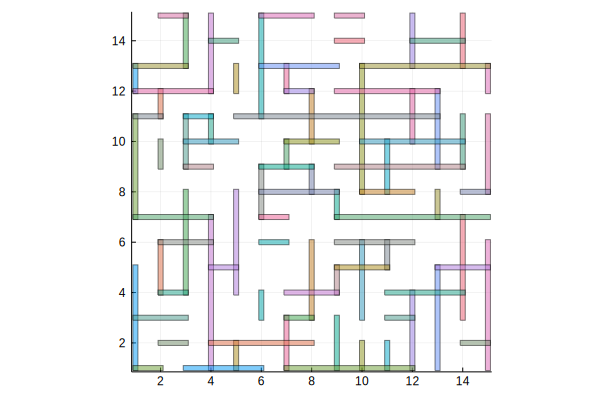

In [54]:
Dibuja(LeeArchivo("rectangulos01.csv"))

# D. Paralelismo y prioridad de branching

Las instancias "rectangulosxx.csv" para xx>=04 son bastante más complejas que las 3 primeras y para abordarlas manipularemos los parámetros del solver. 

### D1 Paralelismo.

El parámetro **threads** (hilos) de Gurobi recibe un número natural $n$. Si $n$ es positivo, entonces Gurobi intentará usar hasta $n$ cores (si es que hay disponibles) para recorrer el árbol de branch and bound. Si $n=0$, Gurobi elige automáticamente el número de hilos a usar (usualmente es el máximo disponible).

En general, activar el paralelismo mejora el rendimiento de Gurobi. Son pocos los casos donde conviene usar solo un hilo. Por ejemplo, podría servir si la memoria es escasa o si hay otros procesos importantes corriendo en el mismo computador. También sirve en instancias en las que cerrar el gap de integralidad es complicado.

Puede cambiar el número de threads asignado a un modelo usando la función ``Modifica`` que se escribió al principio del laboratorio.

```julia
Modifica(mimodelo, ["threads" 0]) # Activa paralelismo
Modifica(mimodelo, ["threads" 1]) # Desactiva paralelismo: 1 solo thread
```

### D2 Prioridad de branching.

Recordemos que cada vez que el solver encuentra un óptimo (fraccional) de un nodo del árbol de branch and bound, debe decidir en que variable fraccional subdividir (hacer "branching"). Usualmente el solver elige adecuadamente de acuerdo a heurísticas internas. Sin embargo, también permite al usuario decidir que variables desea subdividir primero. Para esto, el usuario debe asignar un valor entero, llamado prioridad de branching a cada variable. Cada vez que el solver deba escoger una variable para subdividir, eligirá la variable fraccional con mayor prioridad asignada. 

En ocasiones el usuario (modelador) puede determinar que variables tienen más influencia en la integralidad de la solución. Por ejemplo, si existe una variable $y$ tal que al fijar $y$ a ser entera automáticamente todas las otras se hacen enteras, puede convenir darle mayor prioridad a dicha variable. 

En julia, para cambiar la prioridad de la variable ``x[i]`` del modelo ``m`` al valor ``nuevaprioridad`` puede ejecutar el siguiente comando

```julia
MOI.set(m, Gurobi.VariableAttribute("BranchPriority"), m[:x][i], nuevaprioridad)
```

En este ejercicio revisaremos el efecto de cambiar la prioridad de branching, dandole mayor prioridad a los rectángulos con mayor área discreta (usaremos nuevaprioridad = areadiscreta del rectángulo correspondiente)

## Ejercicio 2:

### 2.1
Diseñe una función ``test`` que siga la siguiente sintaxis de entrada y salida:

```julia
function test(nombrearchivo)
    # Entrega una tabla df (DataFrame) con 3 atributos 
    # "threads"(0/1), "prioridades" (0/1), "tiempo" (Float: tiempo de ejecución)
    return df
```

Su tabla se podría ver como sigue (tabla con valores ficticios)

In [55]:
df = DataFrame(threads = Int8[], prioridades = Int8[], tiempo = Float64[])
push!(df, [0, 0, 0.12])
push!(df, [1, 0, 0.50])
push!(df, [0, 1, 1.99])
push!(df, [1, 1, 5.99])
show(df)

4×3 DataFrame
│ Row │ threads │ prioridades │ tiempo  │
│     │ Int8    │ Int8        │ Float64 │
├─────┼─────────┼─────────────┼─────────┤
│ 1   │ 0       │ 0           │ 0.12    │
│ 2   │ 1       │ 0           │ 0.5     │
│ 3   │ 0       │ 1           │ 1.99    │
│ 4   │ 1       │ 1           │ 5.99    │

Por ejemplo, la tercera fila de la tabla anterior, se interpreta como que la instancia se resolvió en 1.99 segundos al activar la opción "threads" 0, y al usar como prioridades las areas discretas.

Puede completar la plantilla de la siguiente celda para entregar su función.

** Indicación: ** Use el comando ``t=@elapsed optimize!(m)`` para guardar en ``t``  el tiempo que demora en optimizar el modelo ``m``.


In [56]:
function test(nombrearchivo)
    # Recupera familia R
    R = LeeArchivo(nombrearchivo)
    # Crear dataframe vacio
    df = DataFrame(threads = Int8[], prioridades = Int8[], tiempo = Float64[])
    for threads in 0:1
        for prioridades in 0:1
            # Crear modelo con opciones estándar
            m = ModeloMISR(R)
            # Fijar opciones threads 
            Modifica(m, ["Threads" threads])
            # Cambiar prioridades si es necesario
            if (prioridades == 1)
                n = size(R,1)
                for i=1:n
                    nuevaprioridad = AreaDiscreta(R[i,:])
                    MOI.set(m, Gurobi.VariableAttribute("BranchPriority"), m[:x][i], nuevaprioridad)
                end
            end
            
            # Optimizar y medir tiempo
            t = @elapsed optimize!(m)
            # Agregar datos pedidos al dataframe
            push!(df, [threads, prioridades, t])
            
        end
    end
    return df
end

test (generic function with 1 method)

### 2.2 
Pruebe su función test en las 5 primeras instancias de la lista. Cuando termine responda la pregunta al final.

In [75]:
test("rectangulos01.csv")

,threads,prioridades,tiempo
,Int8,Int8,Float64
1,0,0,0.00497802
2,0,1,0.00342213
3,1,0,0.00199382
4,1,1,0.00193672


In [77]:
test("rectangulos02.csv")

,threads,prioridades,tiempo
,Int8,Int8,Float64
1,0,0,2.70482
2,0,1,0.376463
3,1,0,10.0599
4,1,1,0.899937


In [78]:
test("rectangulos03.csv")

,threads,prioridades,tiempo
,Int8,Int8,Float64
1,0,0,1.88077
2,0,1,0.524293
3,1,0,1.57879
4,1,1,0.47792


In [79]:
test("rectangulos04.csv")

,threads,prioridades,tiempo
,Int8,Int8,Float64
1,0,0,24.4917
2,0,1,2.50274
3,1,0,22.0643
4,1,1,2.08265


In [80]:
test("rectangulos05.csv")

,threads,prioridades,tiempo
,Int8,Int8,Float64
1,0,0,30.0378
2,0,1,10.1859
3,1,0,30.0621
4,1,1,15.8324


¿Cuál fue la mejor combinación de parámetros encontrados?

La mejor combinación de parámetros es **prioridades->1** (dar más prioridad de branching a los rectangulos de mayor área), la mejora por el uso de prioridades en el speed up es mucho más notoría en instancias más grandes, lo que es lógico debido a que estas instancias presentan un mayor grado de solapamiento. Para el caso de **threads** no es tan claro cuál es el mejor valor, en algunos casos usar todos los hilos es mejor y en otross usar solo 1 es mejor independiente del valor de **prioridades**, en geneal lamejora por usar más hilos se nota cuando los problemas a resolver son más pesados.

## Ejercicio 3: Uso de cortes.

Los solvers como Gurobi no usan Branch and Bound puro, sino que usan una variante conocida como Branch and Cut.
En esta variante cada vez que un nodo del árbol de B&B se crea, el solver puede añadir restricciones (cortes)
generadas de manera automática. En las últimas clases de este curso veremos algunos de estos en detalle.
En este laboratorio, la idea será principalmente entender cual es el efecto de activar o desactivar ciertos cortes 
en el tiempo de resolución.

El parámetro **Cuts** de gurobi puede tomar valores -1 = automático; 0 = desactivado; 1-2-3 = nivel de agresividad en la generación de cortes de cualquier tipo a no ser que algún tipo específico de corte se active.
Gurobi genera cortes específicos, como por ejemplo CliqueCuts, ZeroHalfCuts y RLTCuts. Cada uno de ellos tiene un parámetro asociado que toma el valor -1 = automático; 0 = desactivado; 1-2-3 (o 1-2 en algunos casos) para el nivel de agresividad.

En este ejercicio desactivaremos los cortes de manera global y probaremos la eficiencia al activar (fijar en 1) la generación de CliqueCuts, ZeroHalfCuts y RLTCuts. En la última parte del laboratorio estudiaremos los CliqueCuts en detalle.

### 3.1
Diseñe una función ``testcuts`` que siga la siguiente sintaxis de entrada y salida:

```julia
function testcuts(nombrearchivo)
    # Entrega una tabla df (DataFrame) con 4 atributos 
    # "CliqueCuts"(0/1), "ZeroHalfCuts" (0/1), "RLTCuts" (0/1), "tiempo" (Float: tiempo de ejecución)
    return df
```
de manera similar al ejercicio anterior. Puede seguir la siguiente plantilla






In [62]:
function testcuts(nombrearchivo)
    # Recupera familia R
    R = LeeArchivo(nombrearchivo)
    # Crear dataframe vacio
    df = DataFrame(CliqueCuts = Int8[], ZeroHalfCuts = Int8[], RLTCuts = Int8[], tiempo = Float64[])
    # "CliqueCuts"(0/1), "ZeroHalfCuts" (0/1), "RLTCuts" (0/1), "tiempo" (Float: tiempo de ejecución)
    for clique in 0:1
        for zerohalf in 0:1
            for rlt in 0:1
                # Crear modelo con opciones estándar
                m = ModeloMISR(R)
                
                # Active Threads = 0  (de lo contrario podrìa ser muy lento su ejecución)
                Modifica(m, ["Threads" 0])
            
                # Fijar resto opciones 
                Modifica(m, ["CliqueCuts"  clique; "ZeroHalfCuts" zerohalf; "RLTCuts" rlt])
               
                # Optimizar y medir tiempo (nota: si llega a tiempo limite, t será aproximadamente 30s)
                t = @elapsed optimize!(m) 
        
                # Agregar datos pedidos al dataframe
                push!(df, [clique, zerohalf, rlt, t])
            end
        end
    end
    
    return df
end

testcuts (generic function with 1 method)

### 3.2
Pruebe su función testcuts en las instancias 6 a 10 de la lista. 
Observe que luego de optimizar el log de gurobi indica el número de cortes de cada tipo usado en la ejecución.

Cuando termine responda la pregunta al final.


In [81]:
testcuts("rectangulos06.csv")

,CliqueCuts,ZeroHalfCuts,RLTCuts,tiempo
,Int8,Int8,Int8,Float64
1,0,0,0,30.072
2,0,0,1,21.5786
3,0,1,0,2.14533
4,0,1,1,2.36863
5,1,0,0,3.45801
6,1,0,1,3.46667
7,1,1,0,3.01444
8,1,1,1,3.52048


In [64]:
testcuts("rectangulos07.csv")

,CliqueCuts,ZeroHalfCuts,RLTCuts,tiempo
,Int8,Int8,Int8,Float64
1,0,0,0,30.0959
2,0,0,1,6.45566
3,0,1,0,2.97153
4,0,1,1,4.20325
5,1,0,0,4.66874
6,1,0,1,5.05405
7,1,1,0,4.81022
8,1,1,1,5.29196


In [65]:
testcuts("rectangulos08.csv")

,CliqueCuts,ZeroHalfCuts,RLTCuts,tiempo
,Int8,Int8,Int8,Float64
1,0,0,0,30.1354
2,0,0,1,9.56181
3,0,1,0,4.48781
4,0,1,1,5.53434
5,1,0,0,6.41887
6,1,0,1,10.0607
7,1,1,0,6.96574
8,1,1,1,11.6386


In [66]:
testcuts("rectangulos09.csv")

,CliqueCuts,ZeroHalfCuts,RLTCuts,tiempo
,Int8,Int8,Int8,Float64
1,0,0,0,30.2048
2,0,0,1,9.90337
3,0,1,0,6.40964
4,0,1,1,7.38229
5,1,0,0,9.77212
6,1,0,1,15.7665
7,1,1,0,15.4901
8,1,1,1,17.139


In [67]:
testcuts("rectangulos10.csv")

,CliqueCuts,ZeroHalfCuts,RLTCuts,tiempo
,Int8,Int8,Int8,Float64
1,0,0,0,30.1895
2,0,0,1,13.9797
3,0,1,0,8.70793
4,0,1,1,11.7487
5,1,0,0,12.8168
6,1,0,1,13.9339
7,1,1,0,13.0352
8,1,1,1,22.0233


¿Cuál fue la mejor combinación de parámetros encontrados?

La mejor combinación es aplicar solo un tipo de corte, **ZeroHalfCuts->1** y de hecho aplicar todos los tipos de cortes es infeciciente, es el segundo peor tiempo seguido de no aplicar ningún corte, esto se debe a que agregar demásiados cortes de forma innecesaria solo perjufica el tiempo de ejecución.

## Ejercicio 4: CliqueCuts

Si en un programa binario con variables $\{x_i\}_{i\in [n]}$, dos variables $x_i$ y $x_j$ son tales que ambas no pueden ser 1 simultáneamente, decimos que $\{i, j\}$ es un **par conflictivo**. Un clique es un conjunto $C \subseteq [n]$ tales que para todo $i, j \in C$, $\{i, j\}$ es conflictivo. Un **clique cut** es cualquier desigualdad de la forma $$\sum_{i\in C}x_i \leq 1$$ donde C es un clique maximal.

Es fácil ver que los clique cuts son desigualdades válidas para todo programa binario (de hecho, la desigualdad es válida incluso si el clique no es maximal), pero que un programa binario podría tener un número exponencial de clique cuts. 

GUROBI  es capaz de generar clique cuts de manera bastante razonable pero es más efectivo (en general) introducir estos cortes de manera explícita si es posible hacerlo.

Para el problema de conjunto independiente de rectángulos, es relativamente sencillo notar que todo clique máximo
corresponde a un conjunto de rectángulos que contienen a un mismo punto. Más aún, si $C$ es un clique entonces el punto
con coordenadas más pequeñas contenido en todos los rectángulos del clique $C$ es 
$(p_C,q_C)=(\max_{i\in C}a_i, \max_{i\in C}b_i)$,

Notamos que $(p_C,q_C)$ es un punto de la grilla $A\times B$ donde $A=\{a_i\colon i\in [n]\}$ y $B=\{b_j\colon j\in [n]\}$. 
Gracias a la discusión anterior todos los clique cuts son de la forma
$$[CQ(p,q)]:\quad \sum_{i\in [n]\colon \text{rect}(a_i,b_i,c_i,d_i) \ni (p,q)} x_i \leq 1$$

Más aún, los clique cuts implican la desigualdad no trivial del modelo (PE), por lo cual podemos crear un modelo (PE2) más fuerte que (PE) como sigue:

$$(PE2)\quad \begin{align*}
  \max &\sum_{i=1} x_i\\
  \sum_{i\in [n]\colon \text{rect}(a_i,b_i,c_i,d_i) \ni (p,q)} x_i &\leq 1\quad  \forall (p,q) \in A\times B\\
  x_i &\in \{0,1\}, \quad \forall i\in [n]
  \end{align*}
  $$
  

### 4.1

Cree una función
```julia
function ModeloMISR2(familia)
return modeloR
```
donde la salida es

* `modeloR` es un objeto de tipo Model (creado por JuMP) basado en la formulación (PE).

y la entrada es

* `familia`:  Matriz que tiene los rectángulos de la familia

Su función debe fijar los siguientes parámetros en el modelo 

 "OutputFlag" 1  <- activa la salida del solver
 
 "TimeLimit" 30  <- limite de tiempo
 
 "Presolver" 0   <- desactiva el presolver
 
 "Threads" 1     <- desactiva el paralelismo (1 solo thread se permite)
 
 "Cuts" 0        <- desactiva la generación de cortes
 
 "Heuristics" 0 <- desactiva las heurísticas

In [68]:
function ModeloMISR2(familia)
    modeloR = Model(optimizer_with_attributes(
                () -> Gurobi.Optimizer(GUROBI_ENV)))
    n = size(familia, 1)   
    
    @variable(modeloR, x[1:n], Bin)
    @objective(modeloR, Max, sum(x))                
    
    A, B = unique(familia[:, 1]), unique(familia[:,2])
    for p in A, q in B
        @constraint(modeloR, sum(x[i] for i in 1:n if Intersecta([p;q;p;q], familia[i,:]))<=1)
    end
    
    Modifica(modeloR, ["OutputFlag" 0; "TimeLimit" 30; "Presolve" 0; "Threads" 1; "Cuts" 0; "Heuristics" 0 ])        
    return modeloR
end

ModeloMISR2 (generic function with 1 method)

## 4.2  

Diseñe una función ``testcliquecuts`` que siga la siguiente sintaxis de entrada y salida:

```julia
function testcliquecuts(nombrearchivo)
    # Entrega una tabla df (DataFrame) con 2 atributos 
    # "modelo" (1/2), "tiempo" (Float: tiempo de ejecución)
    return df
```
de manera similar al ejercicio anterior. 

Aquí "modelo 1" significa resolver la instancia:
* usando ModeloMISR1
* activando el parámetro CliqueCuts=1 de gurobi (pero desactivando todos los otros cortes)

y "modelo 2" significa resolver la instancia:
* usando ModeloMISR2
* sin activar ningún corte ( CliqueCuts tampoco debe estar activado)



In [69]:
function testcliquecuts(nombrearchivo)
    # Entrega una tabla df (DataFrame) con 2 atributos 
    # "modelo" (1/2), "tiempo" (Float: tiempo de ejecución)
    
    # Recupera familia R
    R = LeeArchivo(nombrearchivo)
    # Crear dataframe vacio
    df = DataFrame(modelo = Int8[], tiempo = Float64[])
    
    modelo1 = ModeloMISR(R)
    Modifica(modelo1, ["CliqueCuts" 1])
    t1 = @elapsed optimize!(modelo1)
    push!(df, [1, t1])
    
    modelo2 = ModeloMISR2(R)
    t2 = @elapsed optimize!(modelo2)
    push!(df, [2, t2])
    return df
end

testcliquecuts (generic function with 1 method)

### 4.3
Pruebe su función testcuts en las instancias 6 a 10 de la lista. 
Cuando termine responda la pregunta al final.


In [70]:
testcliquecuts("rectangulos06.csv")

,modelo,tiempo
,Int8,Float64
1,1,2.25806
2,2,0.111239


In [71]:
testcliquecuts("rectangulos07.csv")

,modelo,tiempo
,Int8,Float64
1,1,3.84729
2,2,0.0693577


In [72]:
testcliquecuts("rectangulos08.csv")

,modelo,tiempo
,Int8,Float64
1,1,5.26148
2,2,0.132643


In [73]:
testcliquecuts("rectangulos09.csv")

,modelo,tiempo
,Int8,Float64
1,1,8.58469
2,2,0.72419


In [74]:
testcliquecuts("rectangulos10.csv")

,modelo,tiempo
,Int8,Float64
1,1,11.1211
2,2,0.40846


¿Cuál fue la mejor opción encontrada?

La mejor opción es el modelo 2, agregar los cortes **CliqueCuts** usando el conocimiento a priori del problema dió mejores resultados que el solver que solo implementa los cortes sin tener esta información.